<a href="https://colab.research.google.com/github/sverdoot/DL-in-NLP-course/blob/master/workshop%201/task3_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive word2vec

This task can be formulated very simple. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two layer neural network with matricies $W$ and $W'$.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

Results of your work:
 * trained word vectors (write somewhere, how long it took to train)
 * beautiful visualisations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbours, word analogies
 
Example of visualisation in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)
import numpy as np

import collections, math, os, random, zipfile
import numpy as np

from six.moves import urllib
from six.moves import xrange

url = 'http://mattmahoney.net/dc/'

UNK_TOKEN = '<UNK>'

import requests, os
from os.path import isfile

In [0]:
if not os.path.isfile('text8'):
    with open('data.zip', 'wb') as f:
        r = requests.get('http://mattmahoney.net/dc/text8.zip')
        f.write(r.content)
    !unzip 'data.zip' 

def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = (f.read(f.namelist()[0]).split())
        data = list(map(lambda x: x.decode(), data))
    return data

!ls
#words = read_data('text8')
with open('text8') as f:
    words = f.read().split()

Archive:  data.zip
  inflating: text8                   
data.zip  sample_data  text8


In [0]:
VOCAB_SIZE = 10000
#corpus = [x for x in sentences]
#full_data = [y for x in corpus for y in x]
full_data = words
freq_dict = collections.Counter(full_data)
no_rare_dict = freq_dict.most_common(VOCAB_SIZE)
min_freq = no_rare_dict[-1][1]
vocabulary = [x[0] for x in no_rare_dict]
vocabulary.append(UNK_TOKEN)

data = []
for i, word in enumerate(full_data):
  if freq_dict[word] > min_freq:
    data.append(word)
  else:
    data.append(UNK_TOKEN)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

data_idx = 0

class Batcher:
  
  def __init__(self, batch_size, window_size, data, data_idx=0):
    self.batch_size = batch_size
    self.window_size = window_size
    self.data = data
    
  def __iter__(self):
  
    return self

  def __next__(self, data_idx_=None):
    window_size = self.window_size
    batch_size = self.batch_size
    data = self.data
    global data_idx
    batch = []
    labels = [] 
  
    context = collections.deque(maxlen=2 * window_size + 1)
  
    for _ in range(2 * window_size + 1):
      context.append(word2idx[data[data_idx]])
      data_idx = (data_idx + 1) % len(data)
  
    for i in range(batch_size):
      batch.append([context[j] for  j in list(range(window_size)) + list(range(window_size + 1, 2 * window_size + 1))])
      labels.append(context[window_size])
      context.append(word2idx[data[data_idx]])
      data_idx = (data_idx + 1) % len(data)
    
    return (batch, labels)

In [0]:
def one_hot(batch, voc_size, batch_size=2):  
  if batch_size != 1:
    batch_onehot = torch.zeros(len(batch), voc_size)
    for i, e in enumerate(batch):
      for y in e:
        batch_onehot[i, int(y)] = batch_onehot[i, int(y)] + 1
  else:
    batch_onehot = torch.zeros(voc_size)
    for i in batch:
      batch_onehot[int(i)] = 1
      
  return batch_onehot

In [0]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(CBOW, self).__init__()
        self.linear1 = nn.Linear(vocab_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs):
        out = self.linear1(inputs)
        out = self.linear2(F.relu(out))
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [0]:
import time
part_data = data[:300000]
vocab_size = len(vocabulary)
batch_size = 1000
hidden_size = 20
window_size = 2
print_every = 100

USE_GPU = True

dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device:', device)

model = CBOW(vocab_size=vocab_size, hidden_size=hidden_size)
model = model.to(device=device)
data_idx = 0
batcher = Batcher(batch_size, window_size, part_data)
build_batch = iter(batcher)

loss_function = nn.NLLLoss()

losses = []
it_per_ep = len(part_data) // batch_size

using device: cuda


In [0]:
optimizer = optim.SGD(model.parameters(), lr=1)

In [0]:
start_time = time.clock()
for e in range(30000):
    batch, label = next(build_batch)
    one_hot_vector = one_hot(batch, vocab_size)
    model.train() 
    x = one_hot_vector.to(device=device, dtype=dtype) / window_size 
    scores = model(x).to(device=device, dtype=dtype)
    loss = loss_function(scores, torch.tensor(label, device=device, dtype=torch.long))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if e % it_per_ep == 0:
        print('Iteration %d, loss = %.4lg' % (e, sum(losses[-it_per_ep:])))
        print('Time %lg' % (time.clock() - start_time))
        print()

trained about 10 mins

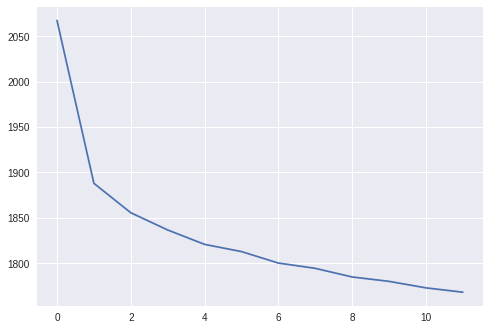

In [0]:
import matplotlib.pyplot as plt
loss_ep = [sum(losses[i * it_per_ep : i * it_per_ep + it_per_ep]) for i in range(len(losses) // it_per_ep)]
plt.plot(loss_ep)

In [0]:
word2vec = lambda x: model.linear1(one_hot([word2idx[x]], vocab_size, batch_size=1).to(device=device, dtype=dtype)).to(device=device, dtype=torch.float).detach().cpu().numpy()
idx2vec = lambda x: model.linear1(one_hot([x], vocab_size, batch_size=1).to(device=device, dtype=dtype)).to(device=device, dtype=torch.float).detach().cpu().numpy()

In [0]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 200
final_embeddings = []
final_embeddings = [idx2vec(i) for i in range(plot_only)]
low_dim_embs = tsne.fit_transform(np.array(final_embeddings))
labels = [idx2word[i] for i in range(plot_only)]

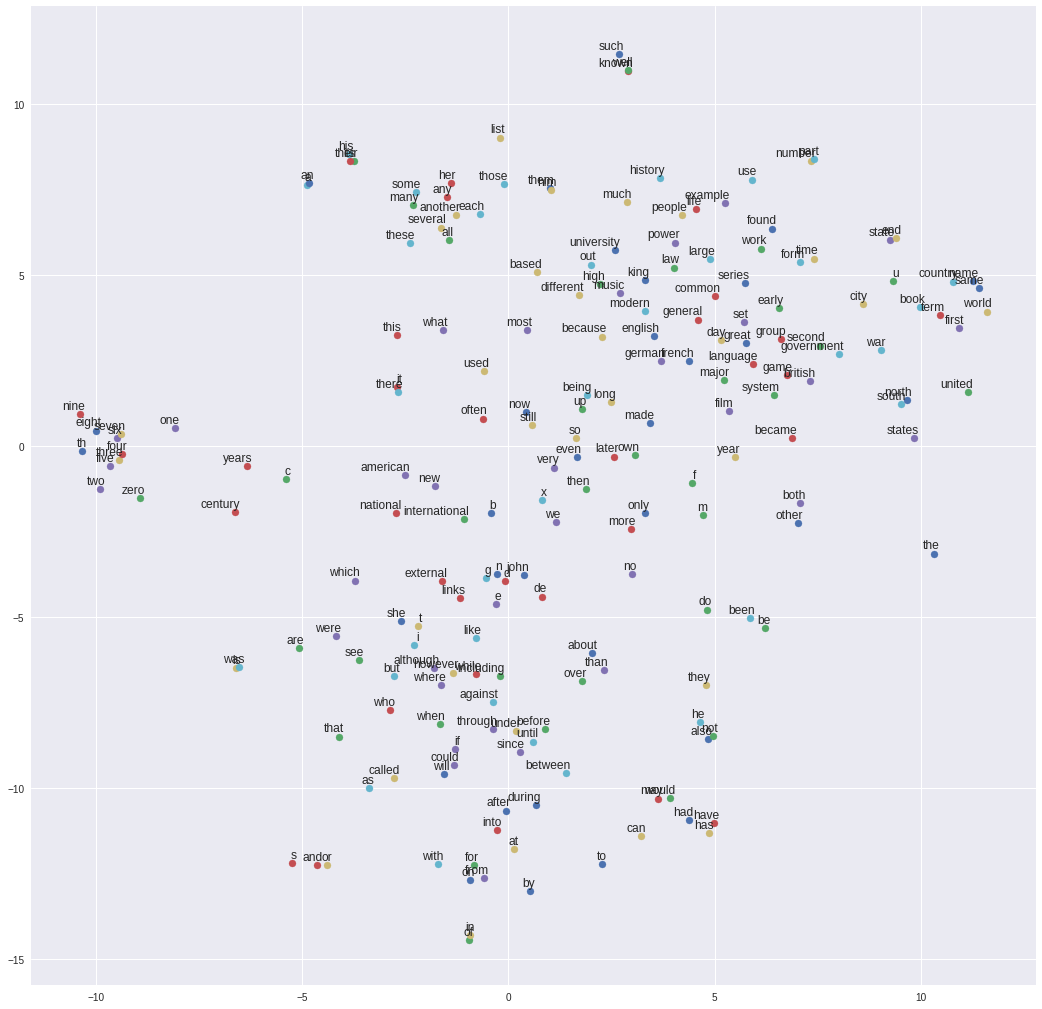

In [0]:
plot_with_labels(low_dim_embs, labels)

In [0]:
def cosine_similarity(word1, word2, word2vec):
  vec1 = word2vec(word1)
  vec2 = word2vec(word2)
  return np.dot(vec1, vec2) / np.linalg.norm(vec1) / np.linalg.norm(vec2)

In [0]:
def nearest_neighbours(words, vocabulary, word2vec, num_neighb=5):
  word_neighb = {}
  for word1 in words:
    similarity = {}
    for word2 in vocabulary:
      similarity[word2] = cosine_similarity(word1, word2, word2vec)
    f = lambda x: similarity[x]
    most_similar = list(similarity.keys())
    most_similar.sort(reverse=True, key=f)
    word_neighb[word1] = most_similar[:num_neighb]
  return word_neighb

In [0]:
nearest_neighbours(['american', 'he', 'year', 'world', 'north', 'may'], vocabulary, word2vec)

{'american': ['american', 'central', 'football', 'south', 'western'],
 'he': ['he', 'not', 'also', 'they', 'considered'],
 'may': ['may', 'would', 'could', 'will', 'should'],
 'north': ['north', 'south', 'west', 'us', 'northern'],
 'world': ['world', 'middle', 'union', 'first', 'name'],
 'year': ['year', 'won', 'minutes', 'seconds', 'k']}

In [0]:
nearest_neighbours(['sea'], vocabulary, word2vec)

{'sea': ['sea', 'antarctic', 'latin', 'prize', 'persian']}

In [0]:
nearest_neighbours(['black'], vocabulary, word2vec)

{'black': ['black', 'via', 'egyptian', 'millennium', 'trade']}

Here are trained vectors actuaully ;)

In [0]:
model.linear1.weight

Parameter containing:
tensor([[ 3.7683e-01,  1.3515e+00, -3.3916e-02,  ...,  8.4823e-03,
         -1.4355e-04, -1.8255e-01],
        [ 5.3080e-01, -6.4560e-01, -4.3860e-01,  ..., -1.1959e-03,
          2.0158e-03, -3.3445e-01],
        [ 5.7642e-02,  2.8104e-01,  2.2399e-01,  ..., -3.6362e-03,
          2.8661e-03, -8.0245e-03],
        ...,
        [ 5.5502e-01,  6.7565e-01,  1.3466e-01,  ..., -9.0609e-03,
          1.6216e-03,  4.4122e-01],
        [ 3.6712e-01, -3.7864e-01, -7.5995e-01,  ...,  5.6700e-03,
         -8.5773e-03, -9.4796e-01],
        [-1.7225e-01, -2.2827e-01, -1.6240e-01,  ..., -8.0151e-03,
         -9.2101e-03, -1.2255e-01]], device='cuda:0', requires_grad=True)

In [0]:
#torch.save(model.state_dict(), './task3')

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#torch.save(model.state_dict(), '/content/drive/My Drive/model_task3')

In [0]:
#model.load_state_dict(torch.load('/content/drive/My Drive/model_task3'))
#model.eval()

CBOW(
  (linear1): Linear(in_features=10001, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=10001, bias=True)
)